In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from itertools import combinations
from sklearn.model_selection import train_test_split    
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import svm
pd.options.display.max_columns=100
from sklearn.cluster import KMeans

In [2]:
# quality of life indicators
cpi = pd.read_csv('cpi.csv')
cpi = cpi[['Country','2015 cpi']]
cpi = cpi.replace('-',np.nan)
cpi['2015 cpi'] = [float(x) for x in cpi['2015 cpi']]
edbi = pd.read_csv('edbiscores.csv')
edbi=edbi.replace('Russian Federation','Russia')
homicide = pd.read_csv('homicide.csv')
pfi = pd.read_csv('pfi.csv')[['Country','Score']]
pfi.columns = ['Country','2018 pfi']
pfi['2018 pfi'] = [float(x) for x in pfi['2018 pfi']]
homicide.columns = ['Country','Region','Subregion','Homicide Rate','Homicide County','Year','Source']
qol = pd.merge(cpi,pfi,on='Country',how='outer')
qol = pd.merge(qol,edbi,on='Country',how='outer')
qol = pd.merge(qol, homicide, on='Country',how='outer')
qol['score'] = qol['2015 cpi'] / qol['2018 pfi'] * qol['DB 2019']
#GDP and Population
data = pd.read_csv('world_indicators_all_years.csv')
data = data[data['Time'] == '2016']
data = data.replace('Iran, Islamic Rep.','Iran').replace('Korea, Dem. People’s Rep.',"Democratic People's Republic of Korea").replace('Lao PDR','Laos').replace('Korea, Rep.','Korea,South').replace('Macedonia, FYR','Macedonia').replace('Myanmar','Myanmar (Burma)').replace('Russian Federation','Russia').replace('Slovak Republic','Slovakia').replace('Syrian Arab Republic','Syria').replace('Venezuela, RB','Venezuela').replace('Yemen, Rep.','Yemen')
data1 = data[['Country Name', 'Population, total [SP.POP.TOTL]','Population growth (annual %) [SP.POP.GROW]','GDP (current US$) [NY.GDP.MKTP.CD]', 'GDP per capita (current US$) [NY.GDP.PCAP.CD]']]
data1 = data1.replace('..',np.nan)
for x in [*data1.columns][1:]:
    data1[x] = [float(i) for i in data1[x]]
data1['Population, total [SP.POP.TOTL]'] = [float(n) for n in data1['Population, total [SP.POP.TOTL]']]
data1 = pd.merge(qol,data1,left_on='Country',right_on='Country Name',how='outer')
#trust=pd.read_csv('self-reported-trust-attitudes.csv')
#trust=trust[trust['Year']==2014]
#data1=pd.merge(data1,trust,left_on='Country',right_on='Entity').drop(['Entity','Code','Year_y'],1)
#treaties
schengen = ['Austria','Belgium','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece',
            'Hungary','Iceland','Italy','Latvia','Liechtenstein','Lithuania','Luxembourg','Malta',
            'Netherlands','Monaco','Norway','Poland','Portugal','San Marino','Slovakia','Slovenia','Spain',
            'Sweden','Switzerland','Vatican City','Ireland','United Kingdom']
common = ['Ireland','United Kingdom']
unionstate = ['Russia','Belarus']
peaceandfriendship = ['India','Bhutan','Nepal']
ca4 = ['El Salvador','Honduras','Guatemala','Nicaragua']
tasman = ['Australia','New Zealand']
andean = ['Bolivia','Ecuador','Colombia','Peru']
caricom = ['Antigua and Barbuda','Barbados', 'Belize', 'Dominica', 'Grenada','Guyana','Jamaica','Saint Kitts and Nevis','Saint Lucia','Saint Vincent and the Grenadines','Suriname','Trinidad and Tobago']
gcc = ['Saudi Arabia','Oman','Kuwait','United Arab Emirates','Bahrain']
eac = ['Kenya','Tanzania','Uganda','South Sudan','Rwanda','Burundi']
table = [schengen+common+unionstate+peaceandfriendship+ca4+tasman+andean+caricom+gcc+eac,['Schengen'] * len(schengen) + ['Common'] * len(common) + ['Union State'] * len(unionstate) + ['Peace and Friendship'] * len(peaceandfriendship) + ['Central America 4'] * len(ca4) + ['Trans-Tasman Agreement'] * len(tasman) + ['Andean Community'] * len(andean) + len(caricom) * ['Caricom'] + len(gcc) * ['Gulf Cooperation Council'] + ['East African Community'] * len(eac)]
treaties = pd.DataFrame(table).transpose()
treaties.columns = ['Country','Treaty']
notreaty = pd.DataFrame([*set(treaties['Country'])^set(data1['Country Name'])])
notreaty['Treaty'] = None
notreaty.columns = ['Country','Treaty']
treaties = pd.concat([notreaty,treaties])
data1 = pd.merge(data1,treaties,how='outer')
#Democracy Index from the EIU
democracy=pd.read_csv('democracyindex2019.csv')
democracy.columns=['Rank', 'Country', 'Democracy Score', 'Electoral process and pluralism',
       'Functioning of government', 'Political participation',
       'Political culture', 'Civil liberties', 'Regime type', 'Region[n 1]',
       'Changes from last year']
data1=pd.merge(data1,democracy,on='Country',how='outer')
#bring it all together
gini=pd.read_csv('gini.csv').iloc[:217].replace('..',np.nan)
data1['gini']=gini[['1990 [YR1990]', '2000 [YR2000]', '2010 [YR2010]', '2011 [YR2011]',
       '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]',
       '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]']].astype(float).mean(axis=1)
combos=list(combinations(data1['Country'],2))
borders=pd.DataFrame(combos).drop_duplicates()
test2=pd.merge(pd.merge(borders,data1.drop('Rank',1),left_on=0,right_on='Country Name',how='inner'),data1.drop('Rank',1),left_on=1,right_on='Country Name',how='inner')
#More statistics
test2.columns = ['Country_x', 'Country_y', 'C', '2015 cpi_x', '2018 pfi_x', 'DB_y018_x',
       'DB_y019_x', 'Region_x', 'Subregion_x', 'Homicide Rate_x',
       'Homicide County_x', 'Year_x', 'Source_x', 'score_x', 'Country Name_x',
       'Population_x',
       'Population growth_x',
       'GDP_x',
       'GDP per capita_x', 'Treaty_x',
       'Democracy Score_x', 'Electoral process and pluralism_x',
       'Functioning of government_x', 'Political participation_x',
       'Political culture_x', 'Civil liberties_x', 'Regime type_x',
       'Region[n_x]_x', 'Changes from last year_x', 'gini_x', 'Country',
       '2015 cpi_y', '2018 pfi_y', 'DB_y018_y', 'DB_y019_y', 'Region_y',
       'Subregion_y', 'Homicide Rate_y', 'Homicide County_y', 'Year_y',
       'Source_y', 'score_y', 'Country Name_y',
       'Population_y',
       'Population growth_y',
       'GDP_y',
       'GDP per capita_y', 'Treaty_y',
       'Democracy Score_y', 'Electoral process and pluralism_y',
       'Functioning of government_y', 'Political participation_y',
       'Political culture_y', 'Civil liberties_y', 'Regime type_y',
       'Region[n_x]_y', 'Changes from last year_y', 'gini_y']
test2['Population difference'] = test2['Population_x'] / test2['Population_y']
test2['Population growth difference'] = test2['Population growth_x']/ test2['Population growth_y']
test2['GDP difference'] = test2['GDP_x'] / test2['GDP_y']
test2['GDP per capita difference'] = test2['GDP per capita_x'] / test2['GDP per capita_y']
test2['Democracy Score difference']=test2['Democracy Score_x']/test2['Democracy Score_y']
test2['Electoral process and pluralism difference']=test2['Electoral process and pluralism_x']/test2['Electoral process and pluralism_y']
test2['Functioning of government difference']=test2['Functioning of government_x']/test2['Functioning of government_y']
test2['Political participation difference']=test2['Political participation_x']/test2['Political participation_y']
test2['Population difference'] = [1/x if x> 1 else x for x in test2['Population difference'] ]
test2['Population growth difference'] = [1/x if x> 1 else x for x in test2['Population growth difference']]
test2['GDP difference'] = [1/x if x> 1 else x for x in test2['GDP difference']]
test2['GDP per capita difference'] = [1/x if x> 1 else x for x in test2['GDP per capita difference']]
#test2 = pd.merge(test2,df2, left_on='Country_x', right_on='Name of country',how='outer').drop('Borders',1)
test2['GDP product'] = test2['GDP_x'] *test2['GDP_y']
test2['GDP per capita in both'] = (test2['GDP_x'] + test2['GDP_y']) / (test2['Population_x'] + test2['Population_y'])
test2 = test2.drop_duplicates('GDP product').reset_index()
df1 = test2
df1['cpi difference'] = df1['2015 cpi_x'] / df1['2015 cpi_y']
#df1['cpi difference'] = [1/x if x> 1 for x in df1['cpi difference'] else x]
df1['GDP sum'] = df1['GDP_x']+df1['GDP_y']
df1['cpi difference'] = [1/x if x> 1 else x for x in df1['cpi difference']]
df1['db difference'] = df1['DB_y019_x'] / df1['DB_y019_y']
df1['db difference'] = [1/x if x> 1 else x for x in df1['db difference']]
df1['pfi difference'] = df1['2018 pfi_x'] / df1['2018 pfi_y']
df1['pfi difference'] = [1/x if x> 1 else x for x in df1['pfi difference']]
df1['homicide difference'] = df1['Homicide Rate_x'] / df1['Homicide Rate_y']
df1['homicide difference'] = [1/x if x> 1 else x for x in df1['homicide difference']]
#df1['trust difference'] = df1['trust1'] / df1['trust2']
#df1['trust difference'] = [1/x if x> 1 else x for x in df1['pfi difference']]
df1['Country Similarity'] = (df1['cpi difference']+df1['db difference']+df1['pfi difference']+df1['homicide difference']) /4
df1['average cpi'] = df1[['2015 cpi_x','2015 cpi_y']].mean(axis=1)
df1['average db'] = df1[['DB_y019_x','DB_y019_y']].mean(axis=1)
df1['average pfi'] = df1[['2018 pfi_x','2018 pfi_y']].mean(axis=1)
df1['average homicide'] = df1[['Homicide Rate_x','Homicide Rate_y']].mean(axis=1)
df1['average Democracy Score']=df1[['Democracy Score_x','Democracy Score_y']].mean(axis=1)
df1['average Electoral process and pluralism']=df1[['Electoral process and pluralism_x','Electoral process and pluralism_y']].mean(axis=1)
df1['average Functioning of Government']=df1[['Functioning of government_x','Functioning of government_y']].mean(axis=1)
df1['average Political participation']=df1[['Political participation_x','Political participation_y']].mean(axis=1)
df1['average Civil Liberties']=df1['Civil liberties_x']/df1['Civil liberties_y']
#df1['average trust'] = df1[['trust1','trust2']].mean(axis=1)
df1['Border Status'] = np.where(df1['Treaty_x'] == df1['Treaty_y'], 'Open', 'Closed')
df1['Combined Population'] = df1['Population_x'] + df1['Population_y']
df1['GDP per capita']=df1['GDP sum']/df1['Combined Population']
df1['viability'] = df1['average cpi'] * df1['average db'] / (df1['average pfi'] * df1['average homicide'])
df1['viability2'] = df1['average cpi'] * df1['average db'] *df1['GDP per capita']/ (df1['average pfi'] * df1['average homicide'])
df1 = df1.drop_duplicates('Combined Population').sort_values('viability', ascending = False).reset_index().drop('index',1)
df1['Status']=df1['Border Status'].replace('Open',1).replace('Closed',0)
df1=df1.replace(np.inf,np.nan)
df1['Same Region']=df1['Region_x']==df1['Region_y']
df1['Same Subregion']=df1['Subregion_x']==df1['Subregion_y']
df1['Same Region']=df1['Same Region'].replace(False,0)
df1['Same Subregion']=df1['Same Subregion'].replace(False,0)
test=df1.dropna(subset=['Country_x','Country_y','2018 pfi_x','2018 pfi_y','GDP_x','GDP_y','GDP per capita_x','GDP per capita_y','2015 cpi_x','2015 cpi_y','DB_y018_x','DB_y018_y','Homicide Rate_x','Homicide Rate_y','Democracy Score_x','Democracy Score_y','Status'])[['Country_x','Country_y','GDP_x','GDP_y','GDP per capita_x','GDP per capita_y','2015 cpi_x','2015 cpi_y','DB_y018_x','DB_y018_y','Homicide Rate_x','Homicide Rate_y','Democracy Score_x','Democracy Score_y','Population_x','Population_y','2018 pfi_x','2018 pfi_y','Status','Same Region','Same Subregion']]
for x in ['2015 cpi','DB_y018','2018 pfi','Homicide Rate','Democracy Score','Population']:
    test['Average '+x]=test[[x+'_x',x+'_y']].mean(axis=1)
test['Population']=test['Population_x']+test['Population_y']
test['GDP']=test['GDP_x']+test['GDP_y']
test['GDP per capita']=test['GDP']/test['Population']
test['worse cpi']=test[['2015 cpi_y','2015 cpi_x']].min(axis=1)
test['worse pfi']=test[['2018 pfi_x','2018 pfi_y']].max(axis=1)
test['worse DB']=test[['DB_y018_y','DB_y018_x']].min(axis=1)
test['worse homicide']=test[['Homicide Rate_y','Homicide Rate_x']].max(axis=1)
test['worse GDP per capita']=test[['GDP per capita_y','GDP per capita_x']].min(axis=1)
test['better cpi']=test[['2015 cpi_y','2015 cpi_x']].max(axis=1)
test['better pfi']=test[['2018 pfi_x','2018 pfi_y']].min(axis=1)
test['better DB']=test[['DB_y018_y','DB_y018_x']].max(axis=1)
test['better homicide']=test[['Homicide Rate_y','Homicide Rate_x']].min(axis=1)
test['better GDP per capita']=test[['GDP per capita_y','GDP per capita_x']].max(axis=1)
test['worse Democracy Score']=test[['Democracy Score_y','Democracy Score_x']].min(axis=1)
test['better Democracy Score']=test[['Democracy Score_y','Democracy Score_x']].max(axis=1)
test

/tmp/ipykernel_16107/2684372256.py:66: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test2=pd.merge(pd.merge(borders,data1.drop('Rank',1),left_on=0,right_on='Country Name',how='inner'),data1.drop('Rank',1),left_on=1,right_on='Country Name',how='inner')
/tmp/ipykernel_16107/2684372256.py:66: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test2=pd.merge(pd.merge(borders,data1.drop('Rank',1),left_on=0,right_on='Country Name',how='inner'),data1.drop('Rank',1),left_on=1,right_on='Country Name',how='inner')
/tmp/ipykernel_16107/2684372256.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df1 = df1.drop_duplicates('Combined Population').sort_values('viability', ascending = False).reset_index().drop('index',1)


Country_x    Country_y         GDP_x         GDP_y  GDP per capita_x  \
69         Iceland       Norway  2.004741e+10  3.710762e+11      59976.942565   
118    Netherlands       Norway  7.772275e+11  3.710762e+11      45669.814802   
125         Norway  Switzerland  3.710762e+11  6.688513e+11      70911.757159   
142        Iceland  Netherlands  2.004741e+10  7.772275e+11      59976.942565   
192        Iceland  Switzerland  2.004741e+10  6.688513e+11      59976.942565   
...            ...          ...           ...           ...               ...   
22637  El Salvador     Honduras  2.679747e+10  2.151694e+10       4223.584579   
22650  El Salvador         Iraq  2.679747e+10  1.714890e+11       4223.584579   
22661     Honduras         Iraq  2.151694e+10  1.714890e+11       2361.160205   
22715  El Salvador        Sudan  2.679747e+10  9.558438e+10       4223.584579   
22722     Honduras        Sudan  2.151694e+10  9.558438e+10       2361.160205   

       GDP per capita_y  2015 cpi_x  2015 cpi_y  DB_y018_x  DB_y018_y  \
69         70911.757159        79.0        87.0      79.30      82.70   
118        70911.757159        87.0        87.0      76.03      82.70   
125        79890.524005        87.0        86.0      82.70      75.68   
142        45669.814802        79.0        87.0      79.30      76.03   
192        79890.524005        79.0        86.0      79.30      75.68   
...                 ...         ...         ...        ...        ...   
22637       2361.160205        39.0        31.0      65.20      58.13   
22650       4609.600694        39.0        16.0      65.20      44.68   
22661       4609.600694        31.0        16.0      58.13      44.68   
22715       2415.038162        39.0        12.0      65.20      45.09   
22722       2415.038162        31.0        12.0      58.13      45.09   

       Homicide Rate_x  Homicide Rate_y  Democracy Score_x  Democracy Score_y  \
69                0.30             0.51               9.58               9.87   
118               0.55             0.51               9.01               9.87   
125               0.51             0.54               9.87               9.03   
142               0.30             0.55               9.58               9.01   
192               0.30             0.54               9.58               9.03   
...                ...              ...                ...                ...   
22637            82.84            56.52               6.15               5.42   
22650            82.84             9.85               6.15               3.74   
22661            56.52             9.85               5.42               3.74   
22715            82.84             5.16               6.15               2.70   
22722            56.52             5.16               5.42               2.70   

       Population_x  Population_y  2018 pfi_x  2018 pfi_y  Status Same Region  \
69         334252.0     5232929.0       14.10        7.63       1        True   
118      17018408.0     5232929.0       10.01        7.63       1        True   
125       5232929.0     8372098.0        7.63       11.27       1        True   
142        334252.0    17018408.0       14.10       10.01       1        True   
192        334252.0     8372098.0       14.10       11.27       1        True   
...             ...           ...         ...         ...     ...         ...   
22637     6344722.0     9112867.0       27.78       45.23       1        True   
22650     6344722.0    37202572.0       27.78       56.56       0           0   
22661     9112867.0    37202572.0       45.23       56.56       0           0   
22715     6344722.0    39578828.0       27.78       71.13       0           0   
22722     9112867.0    39578828.0       45.23       71.13       0           0   

      Same Subregion  Average 2015 cpi  Average DB_y018  Average 2018 pfi  \
69              True              83.0           81.000            10.865   
118                0              87.0           79.365    

In [3]:
def countryfinder(df1,x):
    return pd.concat([df1[df1['Country_x'].str.contains(x)],df1[df1['Country_y'].str.contains(x)]])

# Predict using TensorFlow

In [4]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

2023-07-27 08:12:43.687009: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-27 08:12:43.687026: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
eps=0.001
for x in ['GDP_x','GDP_y','Population_x','Population_y','GDP','Population','Average Population','GDP per capita','worse GDP per capita','better GDP per capita','GDP per capita_x','GDP per capita_y']:
    test[x]=np.log(test.pop(x)+eps)
raw_df=test._get_numeric_data()
neg, pos = np.bincount(raw_df['Status'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 8781
    Positive: 367 (4.18% of total)



In [6]:
cleaned_df = raw_df.copy()

In [7]:
testsize=0.5
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=testsize)
train_df, val_df = train_test_split(train_df, test_size=testsize)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Status'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Status'))
test_labels = np.array(test_df.pop('Status'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (2195,)
Validation labels shape: (2195,)
Test labels shape: (4391,)
Training features shape: (2195, 37)
Validation features shape: (2195, 37)
Test features shape: (4391, 37)


In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model


2023-07-27 08:12:44.746066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-27 08:12:44.746086: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-27 08:12:44.746098: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (archlinux): /proc/driver/nvidia/version does not exist
2023-07-27 08:12:44.746254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [11]:
model = make_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                608       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 625
Trainable params: 625
Non-trainable params: 0
_________________________________________________________________


/home/matthew/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
model.predict(train_features[:10])


1/1 [==============================] - 0s 62ms/step


array([[0.58403045],
       [0.4470247 ],
       [0.23538616],
       [0.76703733],
       [0.67683876],
       [0.7037304 ],
       [0.8410157 ],
       [0.5306775 ],
       [0.8020644 ],
       [0.8039798 ]], dtype=float32)

In [13]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 1.2231


In [14]:
initial_bias = np.log([pos/neg])
initial_bias


array([-3.13229042])

In [15]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])


1/1 [==============================] - 0s 27ms/step


array([[0.09658329],
       [0.03196154],
       [0.05246937],
       [0.07287502],
       [0.1841157 ],
       [0.03611926],
       [0.02457718],
       [0.02232355],
       [0.07457764],
       [0.17176883]], dtype=float32)

In [16]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.1377


In [17]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)


In [18]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [19]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [20]:
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()


In [21]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)


In [22]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))


Epoch 1/100
2/2 [==============================] - 1s 414ms/step - loss: 0.1795 - tp: 23.0000 - fp: 28.0000 - tn: 4175.0000 - fn: 164.0000 - accuracy: 0.9563 - precision: 0.4510 - recall: 0.1230 - auc: 0.8122 - val_loss: 0.1339 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2102.0000 - val_fn: 93.0000 - val_accuracy: 0.9576 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9458
Epoch 2/100
2/2 [==============================] - 0s 16ms/step - loss: 0.1854 - tp: 22.0000 - fp: 40.0000 - tn: 2061.0000 - fn: 72.0000 - accuracy: 0.9490 - precision: 0.3548 - recall: 0.2340 - auc: 0.6782 - val_loss: 0.1323 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2102.0000 - val_fn: 93.0000 - val_accuracy: 0.9576 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9465
Epoch 3/100
2/2 [==============================] - 0s 15ms/step - loss: 0.1890 - tp: 18.0000 - fp: 48.0000 - tn: 2053.0000 - fn: 76.0000 - accuracy: 0.9435 - precision: 0.2727 - recall: 0.1915 - auc

In [23]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()



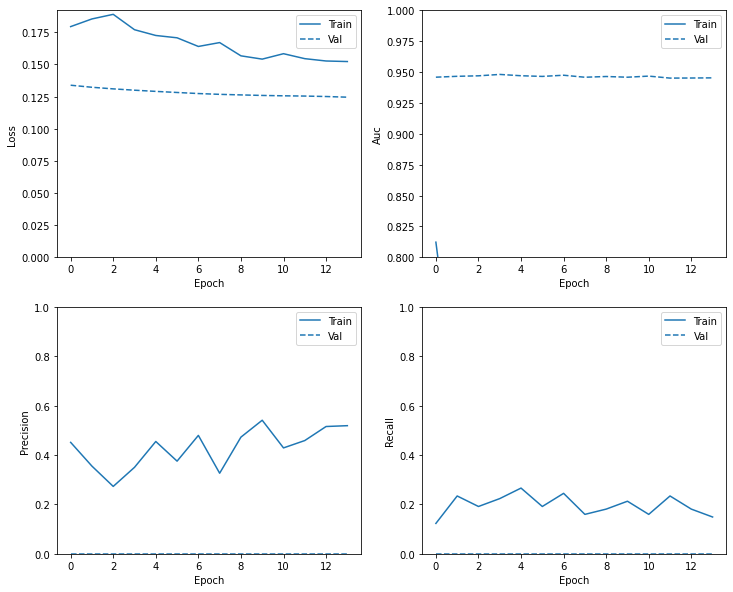

In [24]:
plot_metrics(baseline_history)


In [25]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)


3/3 [==============================] - 0s 738us/step


In [26]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))


loss :  0.13332952558994293
tp :  0.0
fp :  0.0
tn :  4211.0
fn :  180.0
accuracy :  0.9590070843696594
precision :  0.0
recall :  0.0
auc :  0.9020600318908691

Legitimate Transactions Detected (True Negatives):  4211
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  180
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  180


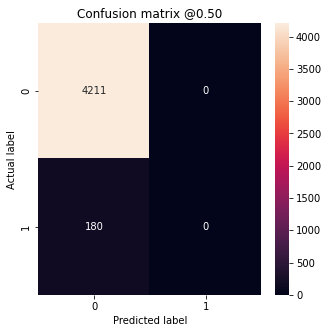

In [27]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)


In [28]:
test_labels

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
test_predictions_baseline

array([[0.06736284],
       [0.25130263],
       [0.04224727],
       ...,
       [0.07971743],
       [0.08633066],
       [0.06882238]], dtype=float32)

In [30]:
test_df

2015 cpi_x  2015 cpi_y  DB_y018_x  DB_y018_y  Homicide Rate_x  \
6417         37.0        79.0      51.29      79.30             6.18   
816          90.0        88.0      80.30      86.59             1.42   
20219        25.0        29.0      49.49      56.78             8.82   
16740        11.0        37.0      37.13      59.42             6.35   
20669        37.0        44.0      65.00      64.66             0.62   
...           ...         ...        ...        ...              ...   
13218        38.0        86.0      57.05      75.68            29.53   
19366        38.0        39.0      60.60      60.93             3.22   
5169         75.0        38.0      79.42      77.39             0.80   
14615        29.0        53.0      56.78      78.29            18.37   
10294        44.0        74.0      53.78      62.26             7.38   

       Homicide Rate_y  Democracy Score_x  Democracy Score_y  2018 pfi_x  \
6417              0.30               5.09               9.58       30.16   
816               0.99               9.25               9.26       10.26   
20219            18.37               3.14               6.15       31.90   
16740             2.55               2.85               6.27       37.28   
20669            33.97               2.26               7.24       78.29   
...                ...                ...                ...         ...   
13218             0.54               6.86               9.03       31.20   
19366            30.88               6.90               7.16       43.24   
5169              3.24               9.24               6.32       14.59   
14615             1.82               6.15               8.22       26.25   
10294             7.69               5.81               8.38       25.61   

       2018 pfi_y  Average 2015 cpi  Average DB_y018  Average 2018 pfi  \
6417        14.10              58.0           65.295            22.130   
816         13.62              89.0           83.445            11.940   
20219       26.25              27.0           53.135            29.075   
16740       41.37              24.0           48.275            39.325   
20669       20.39              40.5           64.830            49.340   
...           ...               ...              ...               ...   
13218       11.27              62.0           66.365            21.235   
19366       22.79              38.5           60.765            33.015   
5169        44.31              56.5           78.405            29.450   
14615       26.45              41.0           67.535            26.350   
10294       15.56              59.0           58.020            20.585   

       Average Homicide Rate  Average Democracy Score  worse cpi  worse pfi  \
6417                   3.240                    7.335       37.0      30.16   
816                    1.205                    9.255       88.0      13.62   
20219                 13.595                    4.645       25.0      31.90   
16740                  4.450                    4.560       11.0      41.37   
20669                 17.295                    4.750       37.0      78.29   
...                      ...                      ...        ...        ...   
13218                 15.035                    7.945       38.0      31.20   
19366                 17.050                    7.030       38.0      43.24   
5169                   2.020                    7.780       38.0      44.31   
14615                 10.095                    7.185       29.0      26.45   
10294                  7.535                    7.095       44.0      25.61   

       worse DB  worse homicide  better cpi  better pfi  better DB  \
6417      51.29            6.18        79.0       14.10      79.30   
816       80.30            1.42        90.0       10.26      86.59   
20219     49.49           18.37        29.0       26.25      56.78   
16740     37.13            6.35        37.0       37.28      59.42   
20669     64.66           33.97        44

In [31]:
px.scatter(x=test_labels,y=test_predictions_baseline)

ValueError: All arguments should have the same length. The length of argument `wide_variable_0` is 1, whereas the length of  previously-processed arguments ['x'] is 4391

In [ ]:
results=test_df
results['True']=test_labels
results['Predicted']=test_predictions_baseline
results=pd.merge(test[['Country_x','Country_y','GDP per capita_x','GDP per capita_y']],results,on=['GDP per capita_x','GDP per capita_y'])#[['Country_x','Country_y']]
results

In [ ]:
px.scatter(results,x='True',y='Predicted',hover_data=['Country_x','Country_y'])

In [ ]:
countryfinder(results,'United States').sort_values('Predicted',ascending=False).head(10)